In [8]:
import os
import glob
import json

import shutil
import requests
import polyline
import gpxpy

import xml.dom.minidom
import itertools

import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx

from geopy.distance import geodesic
from xml.etree.ElementTree import Element, SubElement, tostring

In [9]:
GPX_FILE = "../gpx/30-08-2024/Morning_Run.gpx"
MATCHED_GPX = "../gpx/30-08-2024/Matched_Morning_Run.gpx"

OSMR_URL = "http://127.0.0.1:6000/match/v1/foot"

In [10]:
def osrm_format(coords):
    lat, lon = coords
    return f"{lon},{lat}"

def get_match(points):
    radius_in_meters = 5
    
    radiuses = ';'.join([str(radius_in_meters)] * len(points))
    points = ';'.join(map(osrm_format, points))
    
    params = {
        'geometries': 'polyline6',
        'overview': 'full',
        'tidy': 'true',
        'radiuses': radiuses,
        'gaps': 'ignore'
    } 
    response = requests.get(f"{OSMR_URL}/{points}", params=params)
    routes = response.json()
    
    if routes['code'] != 'Ok':
        print(routes)
        return None
    
    route = [
        polyline.decode(matching['geometry'], 6) 
        for matching in routes['matchings']
    ]

    return list(itertools.chain.from_iterable(route))
               
def create_gpx(route, output_file):
    gpx = Element('gpx', {
      'creator': 'Evgeny Arbatov',
      'xmlns:xsi': 'http://www.w3.org/2001/XMLSchema-instance',
      'xsi:schemaLocation': 'http://www.topografix.com/GPX/1/1 http://www.topografix.com/GPX/1/1/gpx.xsd',
      'version': '1.1',
      'xmlns': 'http://www.topografix.com/GPX/1/1'
    })
    
    trk = SubElement(gpx, "trk")
    trkseg = SubElement(trk, "trkseg")

    for lat, lng in route:
        SubElement(trkseg, "trkpt", attrib={"lat": str(lat), "lon": str(lng)})

    with open(output_file, "w") as f:
        gpx = xml.dom.minidom.parseString(
            tostring(gpx, encoding="unicode")
        ).toprettyxml()
        
        f.write(gpx)
        
def parse_gpx(filepath):
    gpx_file = open(filepath, 'r')
    gpx = gpxpy.parse(gpx_file)

    data = []

    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                lat, lng = point.latitude, point.longitude
                data.append({
                    'lat': lat, 
                    'lon': lng,
                })

    df = pd.DataFrame(data)

    distances = []
    for i in range(1, len(df)):
        prev_point = (df.iloc[i-1]['lat'], df.iloc[i-1]['lon'])
        curr_point = (df.iloc[i]['lat'], df.iloc[i]['lon'])
        distance = geodesic(prev_point, curr_point).meters
        distances.append(distance)

    df['distance'] = [0] + distances
    df['cumulative_distance'] = df['distance'].cumsum()
    
    return df

def plot_gpx(original_df, matched_df):
    plt.figure(figsize=(15, 8))
    plt.plot(original_df['lon'], original_df['lat'], color='blue', label='Original Route')
    plt.plot(matched_df['lon'], matched_df['lat'], color='red', label='Matched Route')
    ctx.add_basemap(plt.gca(), crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
    plt.legend()
    plt.xticks([], [])
    plt.yticks([], [])
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    plt.show()      

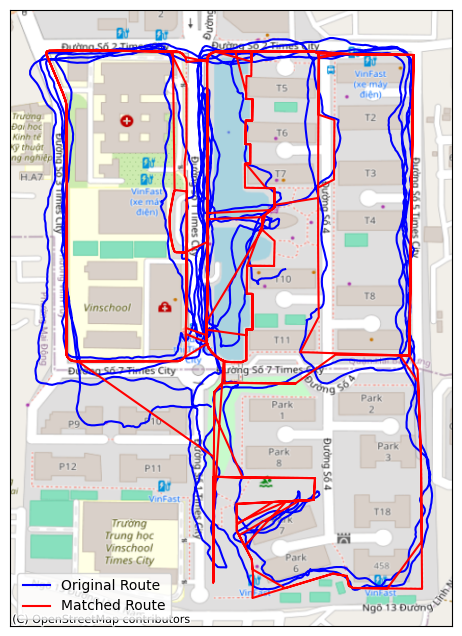

In [11]:
df = parse_gpx(GPX_FILE)

points = list(df[['lat', 'lon']].to_records(index=False))

matched_route = get_match(points)

create_gpx(matched_route, MATCHED_GPX)

matched_df = parse_gpx(MATCHED_GPX)

plot_gpx(df, matched_df)

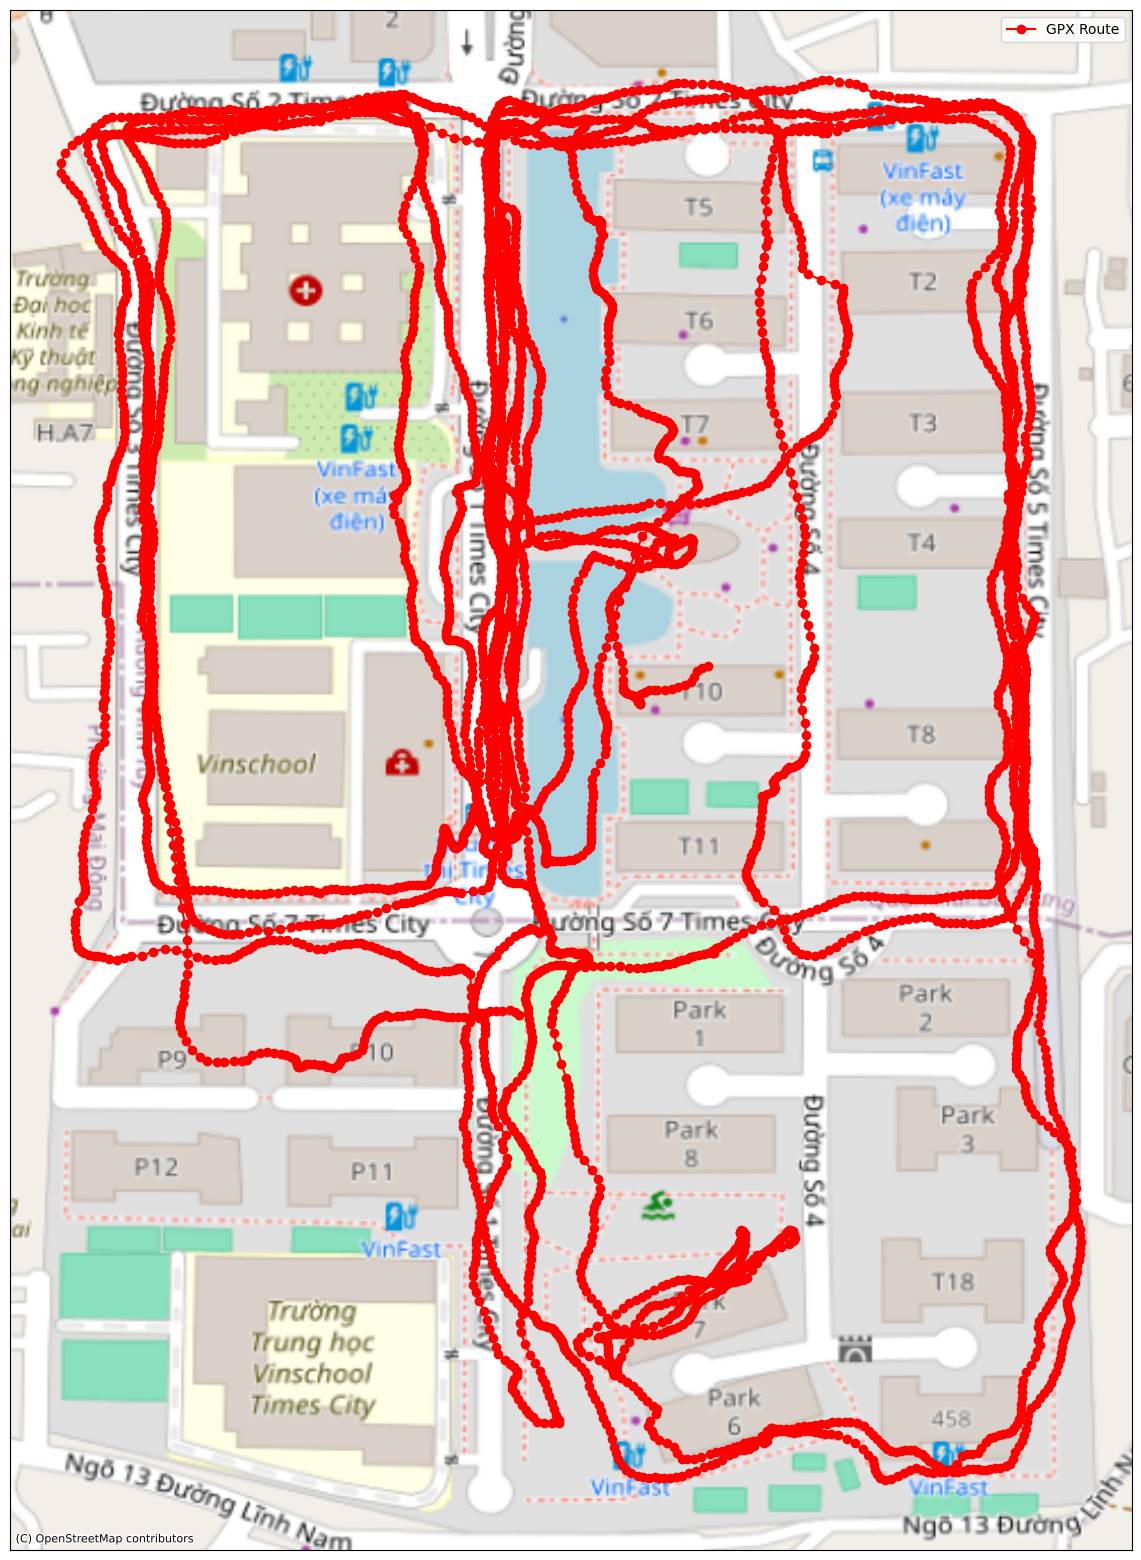

In [16]:
def plot_gpx_route(df):
    plt.figure(figsize=(30, 20))
    plt.plot(df['lon'], df['lat'], color='red', marker='o', label='GPX Route')
    ctx.add_basemap(plt.gca(), crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
    plt.legend()
    plt.xticks([], [])
    plt.yticks([], [])
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    plt.show()    
    
plot_gpx_route(df)

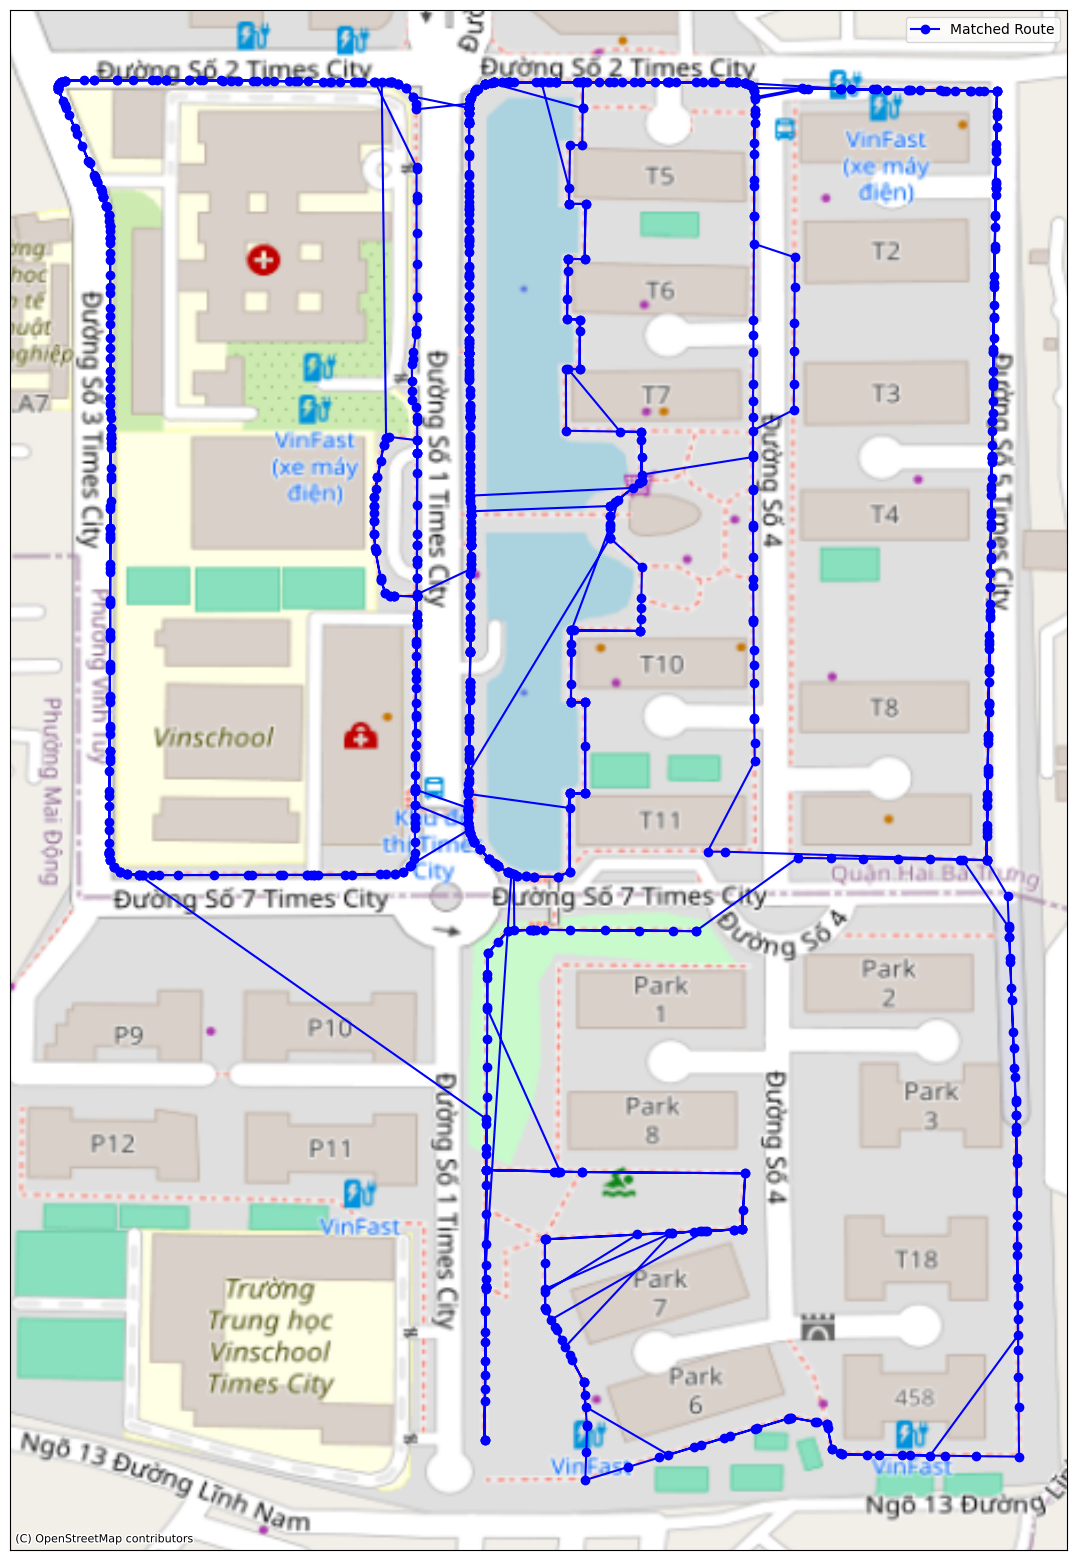

In [15]:
def plot_matched_route(df):
    plt.figure(figsize=(30, 20))
    plt.plot(df['lon'], df['lat'], color='blue', marker='o', label='Matched Route')
    ctx.add_basemap(plt.gca(), crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
    plt.legend()
    plt.xticks([], [])
    plt.yticks([], [])
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    plt.show()    
    
plot_matched_route(matched_df)

In [13]:
print(
    df.iloc[-1]['cumulative_distance'],
    '(original)',
    matched_df.iloc[-1]['cumulative_distance'],
    '(matched)',
)

13735.046972819397 (original) 15229.137862931408 (matched)


In [32]:
df['distance'].describe()

count    4614.000000
mean        2.976820
std         1.004376
min         0.000000
25%         2.444634
50%         3.005587
75%         3.530704
max         9.498711
Name: distance, dtype: float64

In [33]:
matched_df['distance'].describe()

count    1098.000000
mean       13.869889
std        17.203142
min         0.000000
25%         4.695914
50%        12.290464
75%        16.054295
max       204.547420
Name: distance, dtype: float64